In [130]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [131]:
words = open('names.txt','r').read().split('\n')
chars = sorted(list(set(''.join(words))))
S_I = {c:i+1 for i,c in enumerate(chars)}
S_I['.'] = 0
I_S = {i:c for c,i in S_I.items()}

block_size = 8  # context size
vocab_size = len(S_I)
def build_dataset(words):
    # build the dataset
   

    X,Y = [],[] 
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = S_I[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.Tensor(X).long()
    Y = torch.Tensor(Y).long()
    print(X.shape,Y.shape)
    return X,Y

# split into train val and test
random.seed(42)
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train,Y_train = build_dataset(words[:n1]) 
X_val,Y_val = build_dataset(words[n1:n2]) 
X_test,Y_test = build_dataset(words[n2:])   

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [132]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim==2:
        dims = 0
      elif x.ndim==3:
        dims = (0,1)
        
      xmean = x.mean(dims, keepdim=True) # batch mean         # 0,1 to account for 3rd dimension  # mean for both dimensions
      xvar = x.var(dims, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
    
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []
  

# modules for embeddings
class Embedding:
  
  def __init__(self, num_emb, emb_dim):
    self.weight = torch.randn((num_emb, emb_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  

class FlattenConsecutive:
  
    def __init__(self,n):
      self.n = n  
    
    def __call__(self, x):
      B,T,C = x.shape  # 
      x = x.view(B,T//self.n,C*self.n) #  input_dim, groups, emb_dim  4,4,20
      if x.shape[1] == 1: # if context size is 1 return 2d tensor
        x = x.squeeze(1)
      self.out = x
      return self.out
    
    def parameters(self):
      return []


# manage list of layers
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
      self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [133]:
torch.manual_seed(42)

In [134]:
# Network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # to match the number of parameters without wavenet
# C = torch.randn((vocab_size, n_embd))   # Embedding class
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # group 2's  (4,4,20)
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (4,2,400)
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # (4,400)
  Linear(n_hidden, n_hidden)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

89608


In [135]:
ii = torch.randint(0, X_train.shape[0], (4,))
xx , yy = X_train[ii], Y_train[ii]
ll = model(xx)
for layer in model.layers:
  print(layer.__class__.__name__, layer.out.shape)

Embedding torch.Size([4, 8, 24])
FlattenConsecutive torch.Size([4, 4, 48])
Linear torch.Size([4, 4, 128])
BatchNorm1d torch.Size([4, 4, 128])
Tanh torch.Size([4, 4, 128])
FlattenConsecutive torch.Size([4, 2, 256])
Linear torch.Size([4, 2, 128])
BatchNorm1d torch.Size([4, 2, 128])
Tanh torch.Size([4, 2, 128])
FlattenConsecutive torch.Size([4, 256])
Linear torch.Size([4, 128])
BatchNorm1d torch.Size([4, 128])
Tanh torch.Size([4, 128])
Linear torch.Size([4, 128])


In [136]:
max_steps = 50000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  # forward pass
  logits = model(Xb) 
  loss = F.cross_entropy(logits, Yb) # loss function

 # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < max_steps/5 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000== 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  

      0/  50000: 4.8546
   1000/  50000: 2.2673
   2000/  50000: 2.0777
   3000/  50000: 2.1398
   4000/  50000: 1.8588
   5000/  50000: 2.5391
   6000/  50000: 1.7764
   7000/  50000: 2.2120
   8000/  50000: 2.0856
   9000/  50000: 1.7109
  10000/  50000: 2.2022
  11000/  50000: 2.2859
  12000/  50000: 2.0932
  13000/  50000: 2.0946
  14000/  50000: 2.1101
  15000/  50000: 1.8193
  16000/  50000: 1.6098
  17000/  50000: 2.1568
  18000/  50000: 2.0785
  19000/  50000: 1.8517
  20000/  50000: 2.3012
  21000/  50000: 2.1167
  22000/  50000: 2.0437
  23000/  50000: 1.9244
  24000/  50000: 2.2230
  25000/  50000: 1.9314
  26000/  50000: 1.8666
  27000/  50000: 2.3558
  28000/  50000: 1.9769
  29000/  50000: 2.2599
  30000/  50000: 2.0540
  31000/  50000: 2.2383
  32000/  50000: 1.8025
  33000/  50000: 1.6108
  34000/  50000: 1.8386
  35000/  50000: 2.0835
  36000/  50000: 1.8699
  37000/  50000: 2.0216
  38000/  50000: 1.9251
  39000/  50000: 2.0017
  40000/  50000: 2.2537
  41000/  50000:

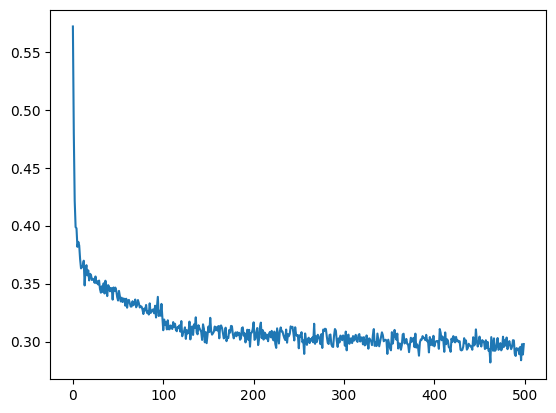

In [137]:
plt.plot(torch.tensor(lossi).view(-1,100).mean(1))

In [138]:
# needed for batch norm to work
for layer in model.layers:
    layer.training = False
    
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.966402292251587
val 2.0315945148468018


In [139]:
# sample from the model
for _ in range(20):
    out = []
    cont = [0] * 3
    while True:
      logits = model(torch.tensor([cont]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      cont = cont[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(I_S[i] for i in out)) # decode and print the generated word

RuntimeError: shape '[1, 1, 48]' is invalid for input of size 72

# Issue
 
* even though the network can be made bigger, the issue lies in the embeddings where all charecters are pushed into a single layer at a single step
* using a wavenet we can slowly go from all charecters to next (dilated causal convolutions)

`for context size of 8, 
* [(1,2),(3,4)],[(5,6),(7,8)]
* group as bigrams in first step, 4's in second ...
* but in paralell